# Regression splines

*The following code tutorial is mainly based on the [scikit learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py) about splines provided by Mathieu Blondel, Jake Vanderplas, Christian Lorentzen and Malte Londschien and code from [Jordi Warmenhoven](https://nbviewer.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%207.ipynb)*. To learn more about the spline regression method, review ["An Introduction to Statistical Learning"](https://www.statlearning.com/) from {cite:p}`James2021`.

- Regression splines involve dividing the range of a feature X into K distinct regions (by using so called knots). Within each region, a polynomial function (also called a Basis Spline or B-splines) is fit to the data.

- In the following example, various piecewise polynomials are fit to the data, with one knot at age=50 {cite:p}`James2021`:

![](https://github.com/kirenz/notebooks/blob/main/ims/_static/img/splines.png?raw=1)

Figures:

- Top Left: The cubic polynomials are unconstrained.
- Top Right: The cubic polynomials are constrained to be continuous at age=50.
- Bottom Left: The cubic polynomials are constrained to be continuous, and to
have continuous first and second derivatives.
- Bottom Right: A linear spline is shown, which is constrained to be continuous.

- The polynomials are ususally constrained so that they join smoothly at the region boundaries, or knots.
- Provided that the interval is divided into enough regions, this can produce an extremely flexibel fit {cite:p}`James2021`:

![](https://github.com/kirenz/notebooks/blob/main/ims/_static/img/splines-2.png?raw=1)

Figure: A cubic spline and a natural cubic spline, with three knots. The dashed lines denote the knot locations.




- To understand the advantages of regression splines, we first start with a linear ridge regression model, build a simple polynomial regression and then proceed to splines.






## Setup

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
import seaborn as sns


- Write function to obtain RMSE for training and test data:

In [2]:
results = []

# create function to obtain model rmse
def model_results(model_name):

    # Training data
    pred_train = reg.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, pred_train, squared=False),4)

    # Test data
    pred_test = reg.predict(X_test)
    rmse_test =round(mean_squared_error(y_test, pred_test, squared=False),4)

    # Save model results
    new_results = {"model": model_name, "rmse_train": rmse_train, "rmse_test": rmse_test}
    results.append(new_results)

    return results;

## Data

### Import

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/kirenz/datasets/master/wage.csv')
df.head(3)

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


### Create label and feature

- We only use the feature age to predict wage (because we only use one predictor, we don't perform data standardization)

In [4]:
X = df[['age']]
y = df[['wage']]

### Data split

- Dividing data into train and test datasets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

### Data exploration

- Visualize the relationship between age and wage:

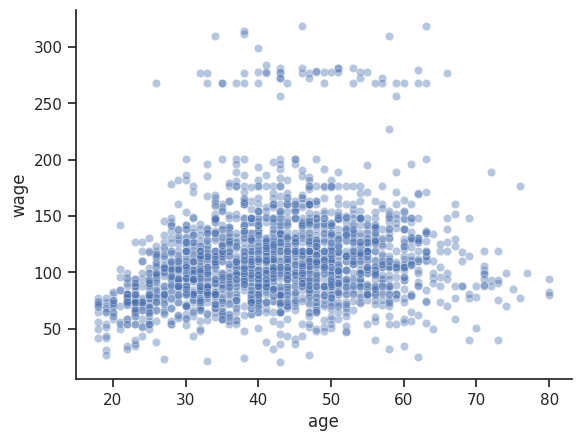

In [6]:
 # seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'], alpha=0.4);

## Ridge regression

- First, we obtain the optimal alpha parameter with cross validation
- We try different values for alpha:

In [7]:
alphas=np.logspace(-6, 6, 13)
alphas

array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])

- Fit model

In [8]:
reg = linear_model.RidgeCV(alphas=alphas)
reg.fit(X_train,y_train)

RidgeCV(alphas=array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ]))

- Show best alpha

In [ ]:
reg.alpha_

1000.0

- Show coefficients

In [ ]:
print(reg.coef_)
print(reg.intercept_)

[[0.71854335]]
[80.69608773]


In [ ]:
model_results(model_name="Ridge")

[{'model': 'Ridge', 'rmse_train': 40.7053, 'rmse_test': 41.4135}]

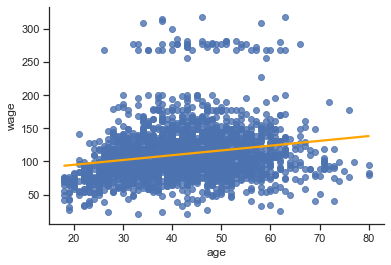

In [ ]:
sns.regplot(x=X_train['age'],
            y=y_train['wage'],
            ci=None,
            line_kws={"color": "orange"});

## Polynomial regression

- Next, we use a pipeline to add non-linear features to a ridge regression model.

- We use [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) which is a shorthand for the Pipeline constructor
    - It does not require, and does not permit, naming the estimators.
    - Instead, their names will be set to the lowercase of their types automatically:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# use polynomial features with degree 3
reg = make_pipeline(
            PolynomialFeatures(degree=3),
            linear_model.RidgeCV(alphas=alphas)
            )

reg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridgecv',
                 RidgeCV(alphas=array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])))])

In [ ]:
model_results(model_name="Polynomial Reg")

[{'model': 'Ridge', 'rmse_train': 40.7053, 'rmse_test': 41.4135},
 {'model': 'Polynomial Reg', 'rmse_train': 39.7717, 'rmse_test': 40.2513}]

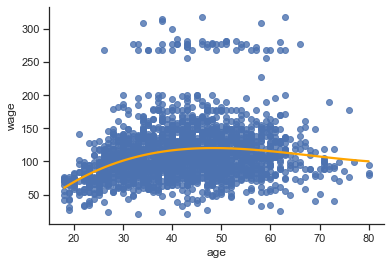

In [ ]:
# plot
sns.regplot(x=X_train['age'],
            y=y_train['wage'],
            ci=None,
            order=3,
            line_kws={"color": "orange"});

## Splines (scikit-learn)

*Note that spline transformers are a new feature in [scikit learn 1.0](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_0_0.html). Therefore, make sure to use the latest version of scikit learn. Use `conda list scikit-learn` to see which scikit-learn version is installed. If you use Anaconda, you can update all packages using `conda update --all`*  

### Spline transformer

- The following function places the knots in a uniform (this is the default) or quantile fashion.

- We only have to specify the desired number of knots, and then have [SplineTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) automatically place the corresponding number of knots.

In [ ]:
from sklearn.preprocessing import SplineTransformer

# use a spline wit 4 knots and 3 degrees
# we combine the spline with a ridge regressions
reg = make_pipeline(
                    SplineTransformer(n_knots=4, degree=3),
                    linear_model.RidgeCV(alphas=alphas)
                    )
reg.fit(X_train, y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=4)),
                ('ridgecv',
                 RidgeCV(alphas=array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])))])

In [ ]:
model_results(model_name = "Cubic Spline")

[{'model': 'Ridge', 'rmse_train': 40.7053, 'rmse_test': 41.4135},
 {'model': 'Polynomial Reg', 'rmse_train': 39.7717, 'rmse_test': 40.2513},
 {'model': 'Cubic Spline', 'rmse_train': 39.7456, 'rmse_test': 40.2444}]

- Obtain knots to show them in the following plot (there are degree number of additional knots each to the left and to the right of the fitted interval. These are there for technical reasons, so we refrain from showing them)

In [ ]:
splt = SplineTransformer(n_knots=4, degree=3)
splt.fit(X_train)
knots = splt.bsplines_[0].t

knots[3:-3]

array([18.        , 38.66666667, 59.33333333, 80.        ])

/Users/jankirenz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


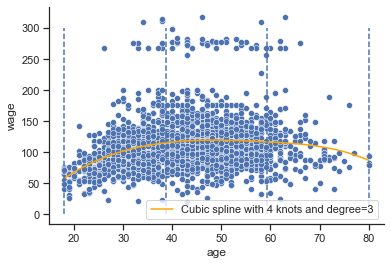

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create observations
x_new = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = reg.predict(x_new)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])

plt.plot(x_new, pred, label='Cubic spline with 4 knots and degree=3', color='orange')
plt.vlines(knots[3:-3], ymin=0, ymax=300, linestyles="dashed")
plt.legend();

### Periodic splines

- In some settings, e.g. in time series data with seasonal effects, we expect a periodic continuation of the underlying signal.
- Such effects can be modelled using periodic splines, which have equal function value and equal derivatives at the first and last knot.
- Review this notebook to learn more about periodic splines in scikit learn: [periodic splines](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#periodic-splines)



## Splines (statsmodels)

- In statsmodels, we can use pandas dataframes so let's join our label and feature:

In [ ]:
df_train = y_train.join(X_train)
df_test = y_test.join(X_test)

df_train

,wage,age
1045,127.115744,45
2717,118.884359,51
2835,104.921507,32
2913,87.981033,58
959,61.052421,50
...,...,...
2763,73.775743,44
905,104.921507,49
1096,148.413159,61
235,81.283253,34



- Instead of providing the number of knots, in statsmodels, we have to specify the degrees of freedom (df).
- `df` defines how many parameters we have to estimate.
- They have a specific relationship with the number of knots and the degree, which depends on the type of spline (see [Stackoverflow](https://stats.stackexchange.com/a/517479)):

- In the case of **B-splines**:
  - $df=𝑘+degree$ if you specify the knots or
  - $𝑘=df−degree$ if you specify the degrees of freedom and the degree.

As an example:

- A cubic spline (degree=3) with 4 knots (K=4) will have $df=4+3=7$ degrees of freedom. If we use an intercept, we need to add an additional degree of freedom.
- A cubic spline (degree=3) with 5 degrees of freedom (df=5) will have $𝑘=5−3=2$ knots (assuming the spline has no intercept).

- In our case, we want to fit a cubic spline (degree=3) with an intercept and three knots (K=3). This equals $df=3+3+1=7$ for our feature. This means that these degrees of freedom are used up by an intercept, plus six basis functions.


In [ ]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

bs = BSplines(X_train[['age']], df=7, degree=3)

/Users/jankirenz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


- We fit a Generalized Additive Model (GAM). To learn more about GAMs, visit [](gam.ipynb).

In [ ]:
reg = GLMGam.from_formula('wage ~ age', data=df_train, smoother=bs).fit()

- Take a look at the results

In [ ]:
print(reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 2100
Model:                         GLMGam   Df Residuals:                     2093
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1582.9
Method:                         PIRLS   Log-Likelihood:                -10712.
Date:                Sat, 23 Apr 2022   Deviance:                   3.3129e+06
Time:                        13:19:11   Pearson chi2:                 3.31e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09038
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.3686     11.185      3.431      0.0

- Obtain RMSE for training and test data:

In [ ]:
model_name = "Spline statsmodels"

# Training data
df_train['pred_train'] = reg.predict()
rmse_train = round(mean_squared_error(df_train['wage'], df_train['pred_train'], squared=False),4)

# Test data
df_test['pred_test'] = reg.predict(df_test, exog_smooth= df_test['age'])
rmse_test = round(mean_squared_error(df_test['wage'], df_test['pred_test'], squared=False),4)

# Save model results
new_results = {"model": model_name, "rmse_train": rmse_train, "rmse_test": rmse_test}
results.append(new_results)

results

[{'model': 'Ridge', 'rmse_train': 40.7053, 'rmse_test': 41.4135},
 {'model': 'Polynomial Reg', 'rmse_train': 39.7717, 'rmse_test': 40.2513},
 {'model': 'Cubic Spline', 'rmse_train': 39.7456, 'rmse_test': 40.2444},
 {'model': 'Spline statsmodels', 'rmse_train': 39.7188, 'rmse_test': 40.2194}]

- We plot the spline with the Statsmodel's function [.plot_partial](https://www.statsmodels.org/devel/generated/statsmodels.gam.generalized_additive_model.GLMGamResults.plot_partial.html):

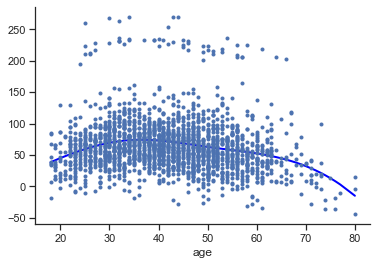

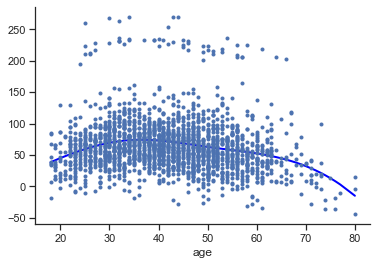

In [ ]:

reg.plot_partial(0, cpr=True, plot_se=False)

### Natural spline

- Finally, we fit a natural spline with [patsy](https://patsy.readthedocs.io/en/latest/) and statsmodels.

- In patsy one can specify the number of degrees of freedom directly (actual number of columns of the resulting design matrix)

- In the case of natural splines: $df=𝑘−1$ if you specify the knots or $𝑘=df+1$ if you specify the degrees of freedom.

In [ ]:
from patsy import dmatrix

bs = dmatrix("cr(train, df = 3)", {"train": X_train}, return_type='dataframe')

- We use statsmodel's "Generalized linear models" (review this [tutorial](https://kirenz.github.io/regression/docs/gam.html) to learn more about GAMs)

In [ ]:
reg = sm.GLM(y_train, bs).fit()

In [ ]:
model_name = 'Natural Spline'

# Training data
pred_train = reg.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
rmse_train = round(mean_squared_error(y_train, pred_train, squared=False),4)

# Test data
pred_test = reg.predict(dmatrix("cr(test, df=3)", {"test": X_test}, return_type='dataframe'))
rmse_test = round(mean_squared_error(y_test, pred_test, squared=False),4)

# Save model results
new_results = {"model": model_name, "rmse_train": rmse_train, "rmse_test": rmse_test}
results.append(new_results)

results

[{'model': 'Ridge', 'rmse_train': 40.7053, 'rmse_test': 41.4135},
 {'model': 'Polynomial Reg', 'rmse_train': 39.7717, 'rmse_test': 40.2513},
 {'model': 'Cubic Spline', 'rmse_train': 39.7456, 'rmse_test': 40.2444},
 {'model': 'Spline statsmodels', 'rmse_train': 39.7188, 'rmse_test': 40.2194},
 {'model': 'Natural Spline', 'rmse_train': 39.8826, 'rmse_test': 40.3252}]

- Plot model

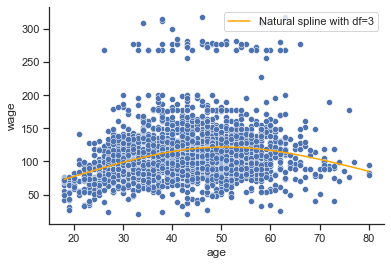

In [ ]:
xp = np.linspace(X_test.min(),X_test.max(), 100)

# Make predictions
pred = reg.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])
plt.plot(xp, pred, color='orange', label='Natural spline with df=3')
plt.legend();

## Models summary

- Create a dataframe from model results

In [ ]:
df_results = pd.DataFrame(results)

df_results.sort_values(by=['rmse_test'])

,model,rmse_train,rmse_test
3,Spline statsmodels,39.7188,40.2194
2,Cubic Spline,39.7456,40.2444
1,Polynomial Reg,39.7717,40.2513
4,Natural Spline,39.8826,40.3252
0,Ridge,40.7053,41.4135
